# Importing libraries

In [36]:
import sys
sys.path.append('/Users/s2223060/Desktop/primordial_features/')
import numpy as np
import matplotlib.pyplot as plt
import emcee, getdist
from mcmc_toolkit import *

We initialise the mcmc object:

In [43]:
#prior to use and start with one walker
priorname = 'lin_simple_range1'
mcmc = MCMC(1, priorname,priors_dir = '/Users/s2223060/Desktop/primordial_features/priors')

#get the number of parameters
ndim = mcmc.ndim
#update the number of walkers to 5 per free parameter
mcmc.set_walkers(5*ndim)
mcmc.change_chain_dir('/Users/s2223060/Desktop/primordial_features/chains')

2024-09-27 15:27:06,373 - mcmc_toolkit - INFO - Using lin_simple_range1 file
2024-09-27 15:27:06,376 - mcmc_toolkit - INFO - Number of walkers set to 25


In [38]:
mcmc.prior_dictionary

OrderedDict([('BNGC', [1, 10]),
             ('BSGC', [1, 10]),
             ('sigma_nl', [0, 35]),
             ('sigma_s', [0, 35]),
             ('a0', [-0.1, 0.1]),
             ('a1', [-0.1, 0.1]),
             ('a2', [-0.1, 0.1]),
             ('a3', [-0.1, 0.1]),
             ('a4', [-0.1, 0.1]),
             ('alpha', [0.8, 1.2]),
             ('A_lin', [-1, 1]),
             ('omega_lin', [100, 900]),
             ('phi', [-0.15915494309189535, 0.15915494309189535])])

Generate some synthetic data and try to recover the input parameters:

In [4]:
from ps_constructor import *

In [5]:
#momentum array
k = np.linspace(1e-3, 0.2, 100)

In [6]:
fn = '/Users/s2223060/Desktop/primordial_features/cosmologies/power_spectrum/BOSS_z1.txt' #Use the BOSS low-Z power spectrum decomposition
ps_model_lin = PowerSpectrumConstructor(fn, 'lin',k)

In [7]:
B = 3
sigma_nl = 0
sigma_s = 0
a0 = 0
a1 = 0
a2 = 0
a3 = 0
a4 = 0
alpha = 1
A = 0.025
omega_lin = 300
phi = 3.14
params = [B,sigma_nl, sigma_s, a0, a1, a2, a3, a4, alpha]

In [8]:
ps_linfeature = ps_model_lin.Evaluate_bare(params + [A, omega_lin, phi])
ps_nofeature = ps_model_lin.Evaluate_bare(params + [0, omega_lin, phi])

Text(0, 0.5, 'k P(k) [Mpc/h]$^{-2}$')

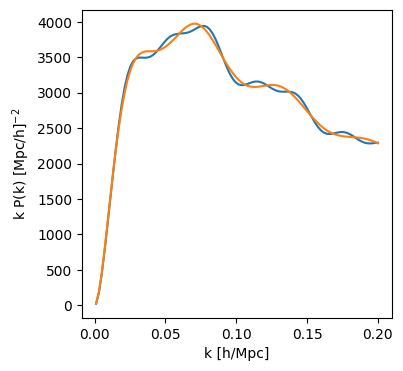

In [9]:
plt.figure(figsize = (4,4))
plt.plot(k, k*ps_linfeature)
plt.plot(k, k*ps_nofeature)
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'k P(k) [Mpc/h]$^{-2}$')

The Gaussian approximation for the covariance matrix of the power spectrum of galaxies is a commonly used approach in cosmology to estimate the uncertainties and correlations in the measured power spectrum. The power spectrum, $P(k)$, describes how the variance of the galaxy density field is distributed over different spatial scales, characterized by the wavenumber $ k $.

In the Gaussian approximation, the covariance matrix $\text{Cov}(P(k_i), P(k_j))$ of the power spectrum $ P(k) $ is given by:

$$
\text{Cov}(P(k_i), P(k_j)) = \frac{2 P(k_i) P(k_j)}{N_{k_i}} \delta_{ij}
$$

where:
- $ P(k_i) $ and $ P(k_j) $ are the power spectrum values at wavenumbers $ k_i $ and $ k_j $, respectively.
- $ N_{k_i} $ is the number of independent modes (or Fourier modes) in the bin centered at $ k_i $.
- $ \delta_{ij} $ is the Kronecker delta, which is 1 if $ i = j $ and 0 otherwise.

This expression assumes that the galaxy density field is a Gaussian random field, which is a reasonable approximation on large scales where the density fluctuations are small. The factor of 2 arises because the power spectrum is a second-order statistic, and the Gaussian approximation assumes that the modes are uncorrelated.

To compute $ N_{k_i} $, you can use:

$$
N_{k_i} = V \frac{k_i^2 \Delta k}{2\pi^2}
$$

where:
- $ V $ is the survey volume.
- $ \Delta k $ is the width of the bin in $ k $-space.

This approximation is useful for estimating the errors on the power spectrum measurements and for constructing likelihood functions for cosmological parameter estimation. However, it is important to note that on smaller scales, where non-linear effects become significant, the Gaussian approximation may break down, and more sophisticated methods may be required to accurately model the covariance matrix.


In [10]:
def gaussian_covariance_matrix(k, Pk, V, delta_k, nbar):
    """
    Compute the Gaussian approximation for the covariance matrix of the power spectrum of galaxies.

    Parameters:
    k (array): Array of wavenumbers.
    Pk (array): Array of power spectrum values corresponding to the wavenumbers.
    V (float): Survey volume.
    delta_k (float): Width of the bin in k-space.

    Returns:
    cov_matrix (2D array): Covariance matrix of the power spectrum.
    """
    # Number of wavenumbers
    N = len(k)
    
    # Initialize the covariance matrix
    cov_matrix = np.zeros((N, N))
    
    # Compute the number of independent modes for each k
    Nk = V * (k**2) * delta_k / (2 * np.pi**2)
    np.fill_diagonal(cov_matrix,2 * Pk**2 / Nk + 1/nbar)
    return cov_matrix

In [11]:
L = 1e3 #Mpc/h
V = (L)**3 #[Mpc/h]^3
delta_k = k[1]-k[0]
nbar = 2e-4
cov = gaussian_covariance_matrix(k,ps_nofeature,V,delta_k,nbar)

Text(0, 0.5, 'k P(k) [Mpc/h]$^{-2}$')

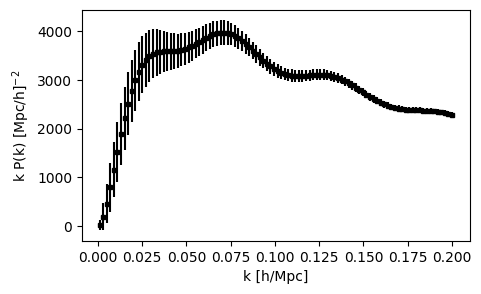

In [12]:
plt.figure(figsize = (5,3))
plt.errorbar(k, k*ps_nofeature, yerr = np.diag(cov)**0.5*k, marker = "s", ls = "", markersize = 3, color = 'black')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'k P(k) [Mpc/h]$^{-2}$')

Finally, we use the covariance matrix to generate a dataset with errors (ie having some shifts around the smooth line):

In [13]:
noise = np.random.multivariate_normal(mean=np.zeros(len(k)), cov=cov)
DATA = ps_linfeature + noise

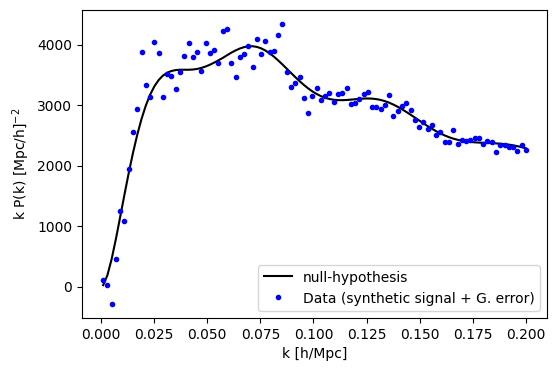

In [14]:
plt.figure(figsize = (6,4))
plt.plot(k, k*ps_nofeature,markersize = 3, color = 'black', label = 'null-hypothesis')
plt.plot(k, k*DATA,markersize = 3, color = 'b', ls = "", marker = "o", label = 'Data (synthetic signal + G. error)')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'k P(k) [Mpc/h]$^{-2}$')
plt.legend()

# Constructing the Likelihood and sampling the posterior

I will assume a flat prior for all parameters:

In [15]:
in_prior = mcmc.in_prior
invcov = np.linalg.inv(cov)

In [16]:
def QuadraticForm(A,B,M):
    """Compute a quadratic form: A.M.B^{T}

    Args:
        A (np.array): The first vector, should be n x 1
        B (np.array): The second vector, should be n x 1
        invCOV (np.array): The matrix. Should be n X n

    Returns:
        float: The result of the quadratic form
    """
    return np.dot(A, np.dot(M,B.T))
    
def loglikelihood(theta):
    
    #Apply a flat prior to some parameters
    if not(in_prior(theta)):
        return(-np.inf)
    params = [theta[0],0,0,0,0,0,0,0,theta[1],theta[2],theta[3],theta[4]]
    theory = ps_model_lin.Evaluate_bare(params)
    
    #Compute chi2
    return -0.5*QuadraticForm(DATA - theory, DATA - theory, invcov)

In [24]:
gelman_rubins = {
    "N":2,
    "epsilon":0.1,
    "min_length":5000,
    "convergence_steps":1000,
    "initial":"uniform_prior"
}

In [18]:
handle = "PrimFeature_lin_tutorial_range1"

In [19]:
initial_pos = [mcmc.create_walkers(mode = "uniform_prior") for i in range(0,gelman_rubin['N'])]

2024-09-27 01:28:47,303 - mcmc_toolkit - INFO - Using uniform prior
2024-09-27 01:28:47,305 - mcmc_toolkit - INFO - Using uniform prior


We will run the chain for 1000 steps

In [20]:
mcmc.run(handle, 1,initial_pos,loglikelihood,gelman_rubins=gelman_rubin,new=False)

2024-09-27 01:28:48,400 - mcmc_toolkit - INFO - You are considering 10 as the minimum length for the chain
2024-09-27 01:28:48,401 - mcmc_toolkit - INFO - Convergence test happens every 1000 steps
2024-09-27 01:28:48,402 - mcmc_toolkit - INFO - Number of walkers: 25
2024-09-27 01:28:48,404 - mcmc_toolkit - INFO - Number of Parameters: 5
2024-09-27 01:28:48,405 - mcmc_toolkit - INFO - Number of parallel chains: 2
2024-09-27 01:28:48,462 - mcmc_toolkit - INFO - Preparing chain 0
2024-09-27 01:28:48,463 - mcmc_toolkit - INFO - Go!
100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 77.76it/s]
2024-09-27 01:28:48,736 - mcmc_toolkit - INFO - Prepared data for Gelman-Rubin diagnostic calculation
2024-09-27 01:28:48,781 - mcmc_toolkit - INFO - Preparing chain 1
2024-09-27 01:28:48,785 - mcmc_toolkit - INFO - Go!
100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 78.27it/s]
2024-09-27 01:28:48,960 - mcmc_toolkit - INFO - Prepared data for Gelman-Rubin diagn

Removed 0.5 as burn in
Removed 0.5 as burn in


2024-09-27 01:28:50,041 - mcmc_toolkit - INFO - 1D plot saved to /Users/s2223060/Desktop/primordial_features/nb/figures/PrimFeature_lin_tutorial_range1_1D_ALL.png
2024-09-27 01:28:50,041 - mcmc_toolkit - INFO - Gelman-Rubin diagnostic calculated: [1.00004803 1.00374151 1.09691167 1.00446342 1.00807959]
2024-09-27 01:28:50,042 - mcmc_toolkit - INFO - epsilon = [4.80287313e-05 3.74150521e-03 9.69116686e-02 4.46342474e-03
 8.07958855e-03]
2024-09-27 01:28:50,042 - mcmc_toolkit - INFO - Convergence Achieved!
2024-09-27 01:28:50,042 - mcmc_toolkit - INFO - Plotting walkers position over steps...
2024-09-27 01:28:51,843 - mcmc_toolkit - INFO - Walkers plot saved to /Users/s2223060/Desktop/primordial_features/nb/figures/PrimFeature_lin_tutorial_range1_walkers.pdf
2024-09-27 01:28:51,843 - mcmc_toolkit - INFO - Plotting the correlation matrix...
2024-09-27 01:28:52,025 - mcmc_toolkit - INFO - Correlation matrix plot saved to /Users/s2223060/Desktop/primordial_features/nb/figures/PrimFeature_li

Removed no burn in
plotting:  ['BNGC', 'alpha']
plotting:  ['BNGC', 'A_lin']
plotting:  ['BNGC', 'omega_lin']
plotting:  ['BNGC', 'phi']
plotting:  ['alpha', 'A_lin']
plotting:  ['alpha', 'omega_lin']
plotting:  ['alpha', 'phi']
plotting:  ['A_lin', 'omega_lin']
plotting:  ['A_lin', 'phi']
plotting:  ['omega_lin', 'phi']


2024-09-27 01:28:59,699 - mcmc_toolkit - INFO - Corner plot saved to /Users/s2223060/Desktop/primordial_features/nb/figures/PrimFeature_lin_tutorial_range1_Corner.png
2024-09-27 01:28:59,699 - mcmc_toolkit - INFO - Done!


We will also explore the parameter space in a region with out any synthetic signal:

In [25]:
#prior to use and start with one walker
priorname = 'lin_simple_range2'
mcmc = MCMC(1, priorname,priors_dir = '/Users/s2223060/Desktop/primordial_features/priors')

#get the number of parameters
ndim = mcmc.ndim

#update the number of walkers to 5 per free parameter
mcmc.set_walkers(5*ndim)

mcmc.change_chain_dir('/Users/s2223060/Desktop/primordial_features/chains/')
mcmc.prior_dictionary
in_prior = mcmc.in_prior

2024-09-27 01:29:32,652 - mcmc_toolkit - INFO - Using lin_simple_range2 file
2024-09-27 01:29:32,654 - mcmc_toolkit - INFO - Number of walkers set to 25


In [26]:
handle = "PrimFeature_lin_tutorial_range2"

In [27]:
initial_pos = [mcmc.create_walkers(mode = "uniform_prior") for i in range(0,gelman_rubins['N'])]

2024-09-27 01:29:33,443 - mcmc_toolkit - INFO - Using uniform prior
2024-09-27 01:29:33,445 - mcmc_toolkit - INFO - Using uniform prior


In [28]:
mcmc.run(handle, 1,initial_pos,loglikelihood,gelman_rubins=gelman_rubins)

2024-09-27 01:29:39,111 - mcmc_toolkit - INFO - You are considering 5000 as the minimum length for the chain
2024-09-27 01:29:39,112 - mcmc_toolkit - INFO - Convergence test happens every 1000 steps
2024-09-27 01:29:39,112 - mcmc_toolkit - INFO - Number of walkers: 25
2024-09-27 01:29:39,113 - mcmc_toolkit - INFO - Number of Parameters: 5
2024-09-27 01:29:39,113 - mcmc_toolkit - INFO - Number of parallel chains: 2
2024-09-27 01:29:39,131 - mcmc_toolkit - INFO - Preparing chain 0
2024-09-27 01:29:39,133 - mcmc_toolkit - INFO - Go!
100%|███████████████████████████████████████| 5000/5000 [01:04<00:00, 77.78it/s]
2024-09-27 01:30:43,453 - mcmc_toolkit - INFO - Prepared data for Gelman-Rubin diagnostic calculation
2024-09-27 01:30:43,453 - mcmc_toolkit - INFO - Preparing chain 1
2024-09-27 01:30:43,453 - mcmc_toolkit - INFO - Go!
100%|███████████████████████████████████████| 5000/5000 [01:06<00:00, 75.74it/s]
2024-09-27 01:31:49,504 - mcmc_toolkit - INFO - Prepared data for Gelman-Rubin dia

Removed 0.5 as burn in
Removed 0.5 as burn in


2024-09-27 01:31:50,586 - mcmc_toolkit - INFO - 1D plot saved to /Users/s2223060/Desktop/primordial_features/nb/figures/PrimFeature_lin_tutorial_range2_1D_ALL.png
2024-09-27 01:31:50,587 - mcmc_toolkit - INFO - Gelman-Rubin diagnostic calculated: [1.00160237 1.00333819 1.00052601 0.99985525 1.00130335]
2024-09-27 01:31:50,587 - mcmc_toolkit - INFO - epsilon = [0.00160237 0.00333819 0.00052601 0.00014475 0.00130335]
2024-09-27 01:31:50,587 - mcmc_toolkit - INFO - Convergence Achieved!
2024-09-27 01:31:50,588 - mcmc_toolkit - INFO - Plotting walkers position over steps...
2024-09-27 01:31:52,481 - mcmc_toolkit - INFO - Walkers plot saved to /Users/s2223060/Desktop/primordial_features/nb/figures/PrimFeature_lin_tutorial_range2_walkers.pdf
2024-09-27 01:31:52,482 - mcmc_toolkit - INFO - Plotting the correlation matrix...
2024-09-27 01:31:52,624 - mcmc_toolkit - INFO - Correlation matrix plot saved to /Users/s2223060/Desktop/primordial_features/nb/figures/PrimFeature_lin_tutorial_range2_Cor

Removed no burn in
plotting:  ['BNGC', 'alpha']
plotting:  ['BNGC', 'A_lin']
plotting:  ['BNGC', 'omega_lin']
plotting:  ['BNGC', 'phi']
plotting:  ['alpha', 'A_lin']
plotting:  ['alpha', 'omega_lin']
plotting:  ['alpha', 'phi']
plotting:  ['A_lin', 'omega_lin']
plotting:  ['A_lin', 'phi']
plotting:  ['omega_lin', 'phi']


2024-09-27 01:31:59,515 - mcmc_toolkit - INFO - Corner plot saved to /Users/s2223060/Desktop/primordial_features/nb/figures/PrimFeature_lin_tutorial_range2_Corner.png
2024-09-27 01:31:59,515 - mcmc_toolkit - INFO - Done!
